<a href="https://colab.research.google.com/github/Umanginigam/Bank-loan_Status/blob/main/bank_loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install matplotlib seaborn


In [ ]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("Bank Loan Preprocessing") \
    .getOrCreate()


In [ ]:
# Load the dataset
file_path = "/content/loan_data.csv"  # Replace with the actual file path
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Show dataset schema
data.printSchema()
data.show(5)


root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+----------------

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
null_counts.show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|     5|      0|         8|        0|           21|              0|                0|         0|              11|            30|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [ ]:
if 'Self_Employed' in data.columns:
    data = data.drop('Self_Employed')
if 'Loan_ID' in data.columns:
    data = data.drop('Loan_ID')

In [ ]:
data.show()

+------+-------+----------+------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|   Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|  Male|    Yes|         1|    Graduate|           4583|           1508.0|     128.0|           360.0|           1.0|        Rural|          N|
|  Male|    Yes|         0|    Graduate|           3000|              0.0|      66.0|           360.0|           1.0|        Urban|          Y|
|  Male|    Yes|         0|Not Graduate|           2583|           2358.0|     120.0|           360.0|           1.0|        Urban|          Y|
|  Male|     No|         0|    Graduate|           6000|              0.0|     141.0|           360.0|           1.0|        Urban|     

In [ ]:
from pyspark.sql.functions import col, mean, lit, when, count

# Handle missing numerical values
numerical_cols = ["LoanAmount", "Loan_Amount_Term", "ApplicantIncome", "CoapplicantIncome"]
for col_name in numerical_cols:
    mean_value = data.select(mean(col(col_name))).first()[0]
    data = data.withColumn(col_name, when(col(col_name).isNull(), lit(mean_value)).otherwise(col(col_name)))

# Handle missing categorical values
categorical_cols = ["Gender","Education", "Dependents", "Credit_History", "Married", "Property_Area","Loan_Status"]
for col_name in categorical_cols:
    mode_value = data.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]
    data = data.withColumn(col_name, when(col(col_name).isNull(), lit(mode_value)).otherwise(col(col_name)))


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_Index") for col_name in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col_name}_Index", outputCol=f"{col_name}_Vec") for col_name in categorical_cols]

# Create a pipeline for transformations
pipeline = Pipeline(stages=indexers + encoders)
data = pipeline.fit(data).transform(data)

data.show(5)


+------+-------+----------+------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+---------------+----------------+--------------------+-------------+-------------------+-----------------+-------------+-------------+--------------+------------------+-------------+-----------------+---------------+
|Gender|Married|Dependents|   Education|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Gender_Index|Education_Index|Dependents_Index|Credit_History_Index|Married_Index|Property_Area_Index|Loan_Status_Index|   Gender_Vec|Education_Vec|Dependents_Vec|Credit_History_Vec|  Married_Vec|Property_Area_Vec|Loan_Status_Vec|
+------+-------+----------+------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+------------+---------------+----------------+--------------------+-------------+-------------------+----------

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Combine numerical features into a single vector
numerical_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

# Scale features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_features", withStd=True, withMean=True)

pipeline = Pipeline(stages=[assembler, scaler])
data = pipeline.fit(data).transform(data)

data.select("scaled_features").show(5, truncate=False)


+-------------------------------------------------------------+
|scaled_features                                              |
+-------------------------------------------------------------+
|[0.7065397186061776,0.09856580402031687,0.8115081150981942]  |
|[-0.408395197236527,-0.5456534076763797,-1.3747880407924848] |
|[-0.7020956772784777,0.4616867124700464,0.5294053853058485]  |
|[1.7045578965904558,-0.5456534076763797,1.2699250510107558]  |
|[-0.8781751017640596,0.10198341257043197,-0.3521656452952318]|
+-------------------------------------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import expr

data = data.withColumn("Total_Income", col("ApplicantIncome") + col("CoapplicantIncome"))
data = data.withColumn("Income_to_Loan_Ratio", col("Total_Income") / col("LoanAmount"))

data.select("Total_Income", "Income_to_Loan_Ratio").show(5)


+------------+--------------------+
|Total_Income|Income_to_Loan_Ratio|
+------------+--------------------+
|      6091.0|          47.5859375|
|      3000.0|   45.45454545454545|
|      4941.0|              41.175|
|      6000.0|    42.5531914893617|
|      3849.0|   40.51578947368421|
+------------+--------------------+
only showing top 5 rows



In [ ]:
final_features = ["scaled_features", "Gender_Vec", "Dependents_Vec", "Credit_History_Vec", "Property_Area_Vec"]
assembler = VectorAssembler(inputCols=final_features, outputCol="final_features")

data = assembler.transform(data)

# Prepare the final dataset with features and target variable
final_data = data.select("final_features", "Loan_Status")
final_data.show(5)


+--------------------+-----------+
|      final_features|Loan_Status|
+--------------------+-----------+
|[0.70653971860617...|          N|
|[-0.4083951972365...|          Y|
|[-0.7020956772784...|          Y|
|[1.70455789659045...|          Y|
|[-0.8781751017640...|          Y|
+--------------------+-----------+
only showing top 5 rows



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Convert to Pandas DataFrame
data_pd = data.toPandas()


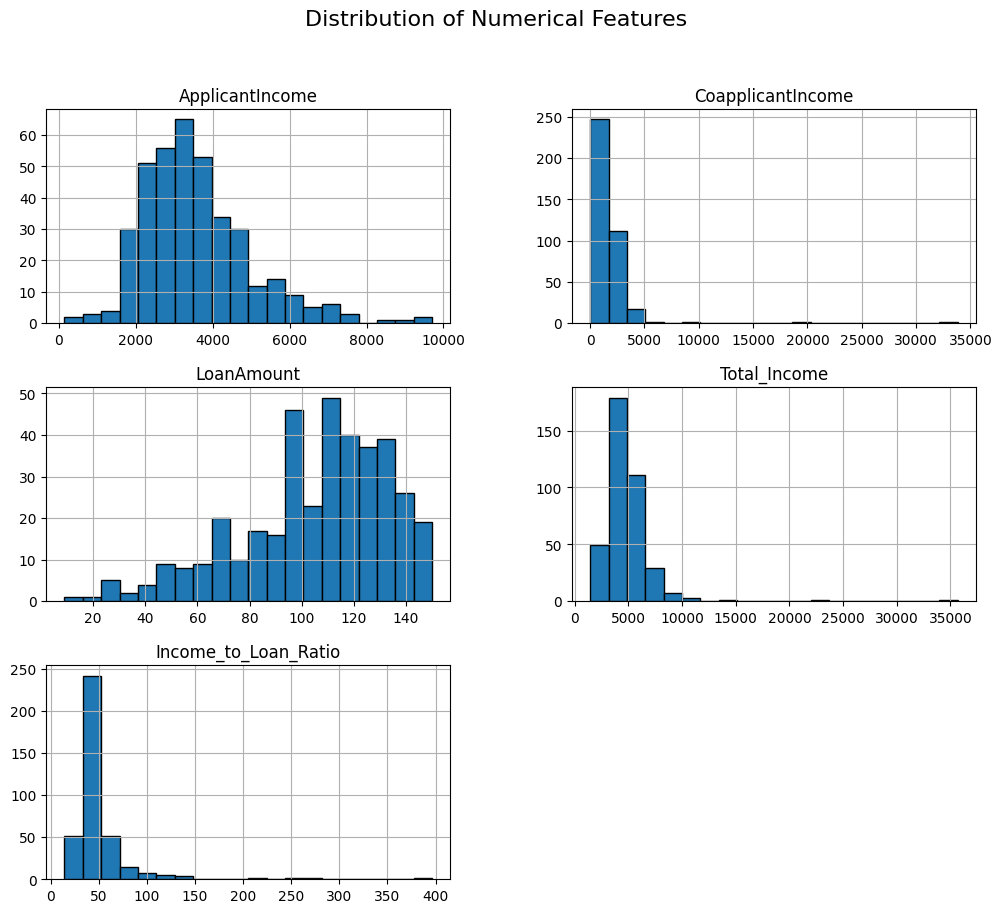

In [ ]:
# Plot histograms for numerical features
numerical_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Total_Income", "Income_to_Loan_Ratio"]
data_pd[numerical_cols].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()




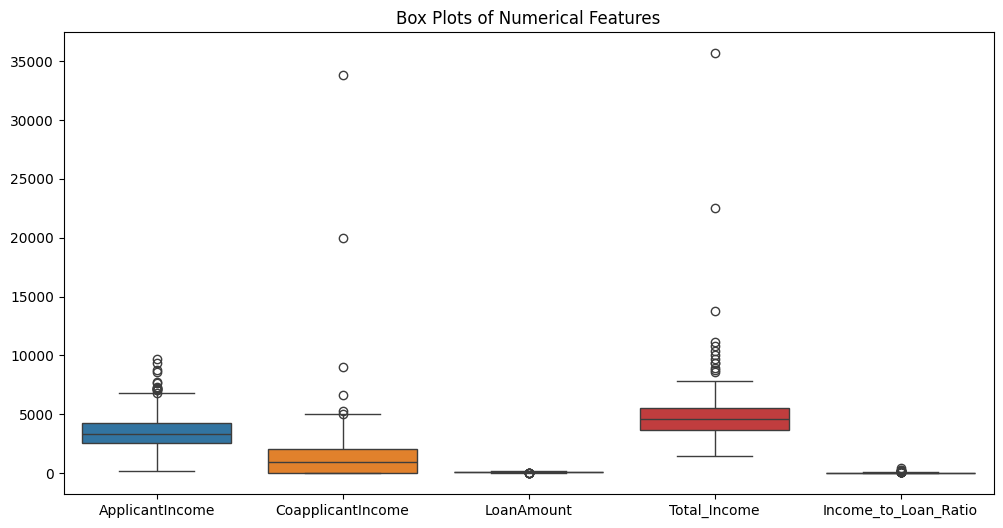

In [ ]:
# Box plots for outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_pd[numerical_cols])
plt.title("Box Plots of Numerical Features")
plt.show()

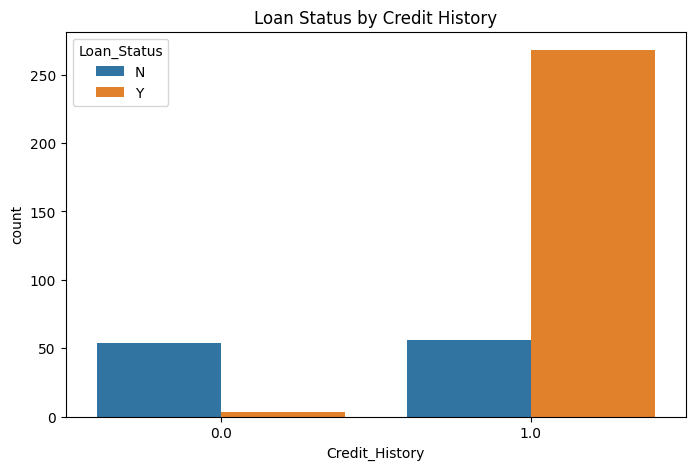

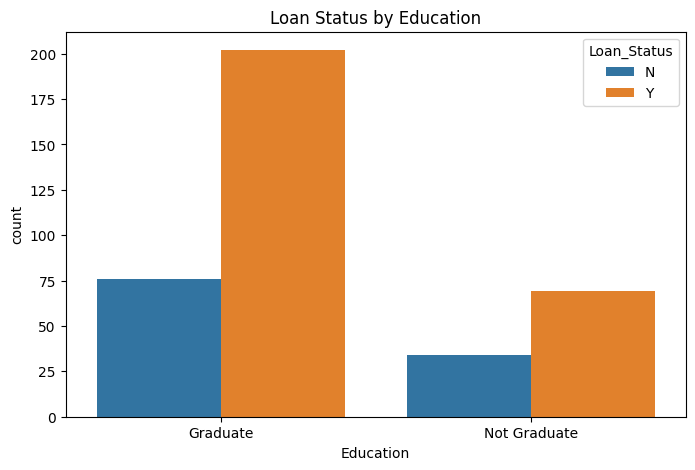

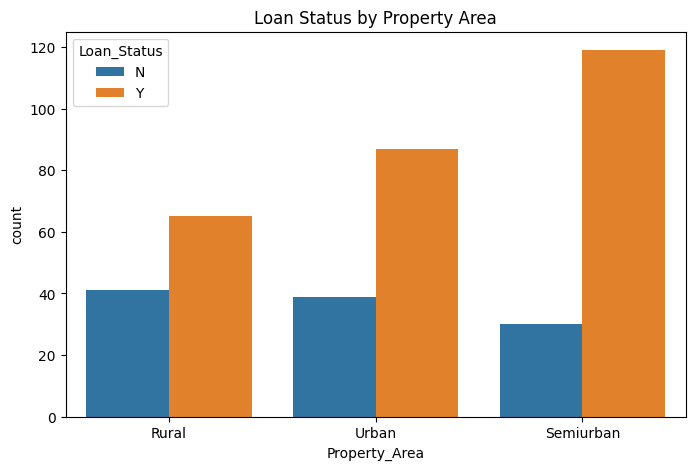

In [ ]:
# Credit History vs Loan Status
plt.figure(figsize=(8, 5))
sns.countplot(x="Credit_History", hue="Loan_Status", data=data_pd)
plt.title("Loan Status by Credit History")
plt.show()

# Education vs Loan Status
plt.figure(figsize=(8, 5))
sns.countplot(x="Education", hue="Loan_Status", data=data_pd)
plt.title("Loan Status by Education")
plt.show()

# Property Area vs Loan Status
plt.figure(figsize=(8, 5))
sns.countplot(x="Property_Area", hue="Loan_Status", data=data_pd)
plt.title("Loan Status by Property Area")
plt.show()


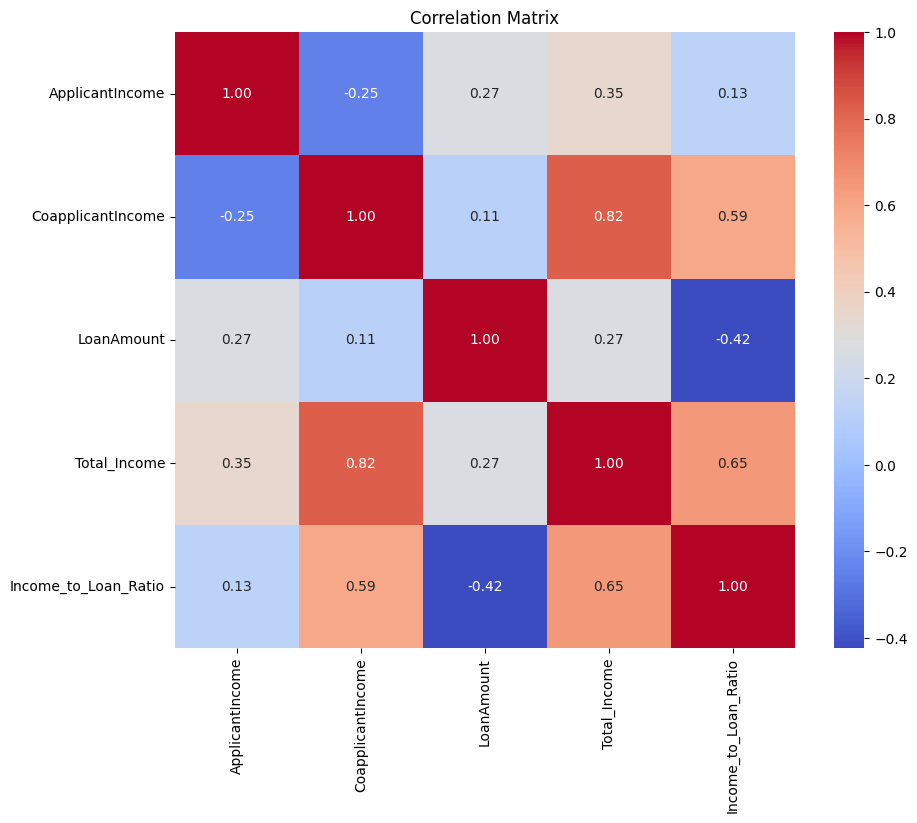

In [ ]:
# Compute correlation matrix
correlation_matrix = data_pd[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


<ipython-input-18-45f7507d9bf6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


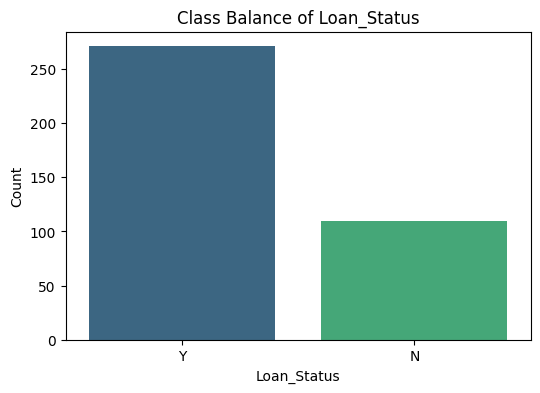

Class Distribution:
 Loan_Status
Y    271
N    110
Name: count, dtype: int64


In [ ]:
# Check class balance
class_counts = data_pd["Loan_Status"].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Balance of Loan_Status")
plt.xlabel("Loan_Status")
plt.ylabel("Count")
plt.show()

# Print class distribution
print("Class Distribution:\n", class_counts)


In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare features and label column
data = data.withColumn("label", col("Loan_Status_Index").cast("integer"))  # Ensure the label is numerical
final_data = data.select("final_features", "label")

# Split data
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="final_features", labelCol="label")

# Hyperparameter tuning for Decision Tree
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

dt_crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=dt_param_grid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"),
    numFolds=3
)

dt_model = dt_crossval.fit(train_data)


In [ ]:
# Fit the model using cross-validation
dt_model = dt_crossval.fit(train_data)

# Extract the best model from the cross-validation
best_dt_model = dt_model.bestModel  # This gives you the best model from the cross-validation

# Make predictions on the test data
dt_predictions = best_dt_model.transform(test_data)

In [ ]:
# Linear SVC
svm = LinearSVC(featuresCol="final_features", labelCol="label")

# Hyperparameter tuning for SVM
svm_param_grid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 50, 100]) \
    .addGrid(svm.regParam, [0.1, 0.01]) \
    .build()

svm_crossval = CrossValidator(
    estimator=svm,
    estimatorParamMaps=svm_param_grid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"),
    numFolds=3
)

svm_model = svm_crossval.fit(train_data)
best_svm_model = svm_model.bestModel
svm_predictions = best_svm_model.transform(test_data)

In [ ]:
# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# Decision Tree Evaluation
dt_predictions = dt_model.bestModel.transform(test_data)
dt_accuracy = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")

# SVM Evaluation
svm_predictions = svm_model.bestModel.transform(test_data)
svm_accuracy = evaluator.evaluate(svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")




Decision Tree Accuracy: 0.875
SVM Accuracy: 0.875


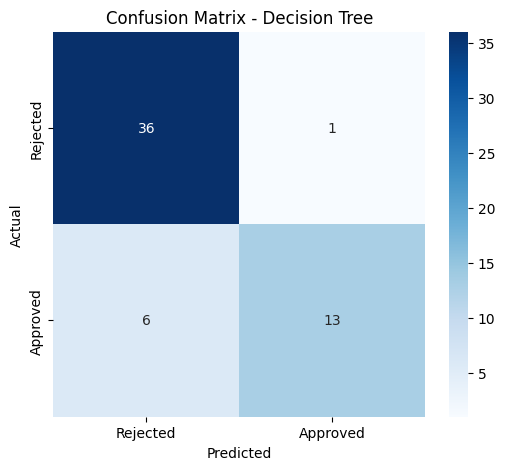

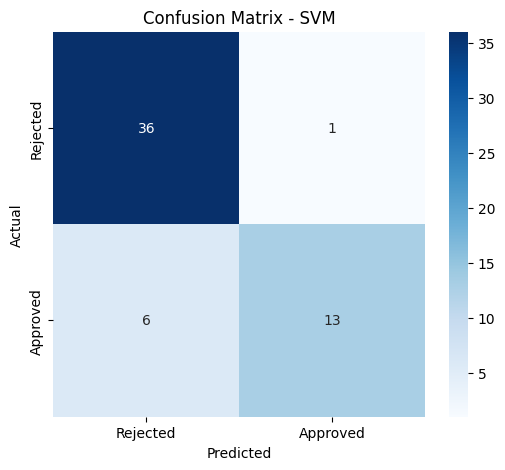

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# For Decision Tree
dt_predictions = best_dt_model.transform(test_data)
dt_pred_labels = dt_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
dt_true_labels = dt_predictions.select("label").rdd.flatMap(lambda x: x).collect()

# Confusion Matrix
dt_conf_matrix = confusion_matrix(dt_true_labels, dt_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(dt_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# For SVM
svm_predictions = best_svm_model.transform(test_data)
svm_pred_labels = svm_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
svm_true_labels = svm_predictions.select("label").rdd.flatMap(lambda x: x).collect()

# Confusion Matrix
svm_conf_matrix = confusion_matrix(svm_true_labels, svm_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Rejected", "Approved"], yticklabels=["Rejected", "Approved"])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




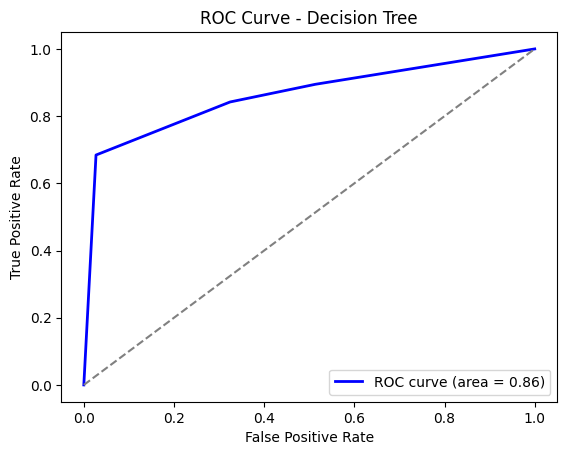

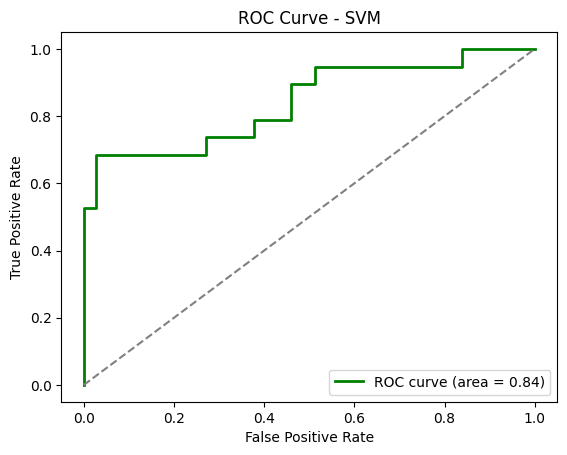

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve, auc

# For Decision Tree
dt_probabilities = dt_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
dt_labels = dt_predictions.select("label").rdd.flatMap(lambda x: x).collect()

# Compute ROC curve for Decision Tree
fpr, tpr, _ = roc_curve(dt_labels, dt_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve for Decision Tree
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

#svm
svm_probabilities = svm_predictions.select("rawPrediction").rdd.map(lambda row: row[0][1]).collect()
svm_labels = svm_predictions.select("label").rdd.flatMap(lambda x: x).collect()

# Compute ROC curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(svm_labels, svm_probabilities)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC Curve for SVM
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()


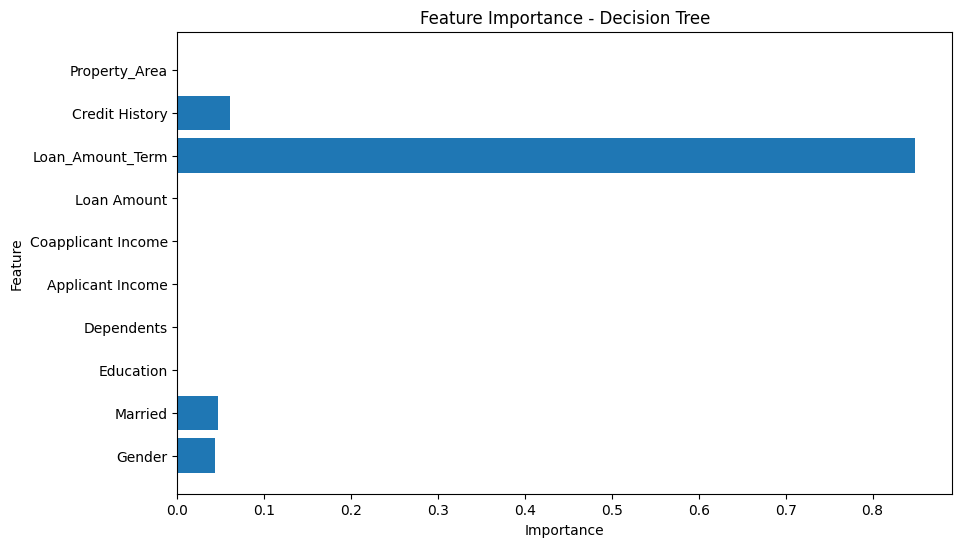

In [ ]:
# Extract the feature importance from the Decision Tree model
feature_importances = best_dt_model.featureImportances

# Get the feature names
feature_names = ["Gender", "Married", "Education", "Dependents", "Applicant Income", "Coapplicant Income", "Loan Amount", "Loan_Amount_Term", "Credit History", "Property_Area"]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# Precision, Recall, and F1-Score
for model_name, predictions in [("Decision Tree", dt_predictions), ("SVM", svm_predictions)]:
    precision = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision").evaluate(predictions)
    recall = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall").evaluate(predictions)
    f1_score = MulticlassClassificationEvaluator(labelCol="label", metricName="f1").evaluate(predictions)

    print(f"{model_name} - Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")


Decision Tree - Precision: 0.881377551020408, Recall: 0.875, F1-Score: 0.8694859992328346
SVM - Precision: 0.881377551020408, Recall: 0.875, F1-Score: 0.8694859992328346


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# For Decision Tree
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_mse = evaluator_mse.evaluate(dt_predictions)
dt_mae = evaluator_mae.evaluate(dt_predictions)
dt_r2 = evaluator_r2.evaluate(dt_predictions)

print(f"Decision Tree Metrics:")
print(f"RMSE: {dt_rmse}, MSE: {dt_mse}, MAE: {dt_mae}, R2: {dt_r2}")

# For SVM
svm_rmse = evaluator_rmse.evaluate(svm_predictions)
svm_mse = evaluator_mse.evaluate(svm_predictions)
svm_mae = evaluator_mae.evaluate(svm_predictions)
svm_r2 = evaluator_r2.evaluate(svm_predictions)

print(f"SVM Metrics:")
print(f"RMSE: {svm_rmse}, MSE: {svm_mse}, MAE: {svm_mae}, R2: {svm_r2}")


Decision Tree Metrics:
RMSE: 0.3535533905932738, MSE: 0.12500000000000003, MAE: 0.125, R2: 0.44238975817923176
SVM Metrics:
RMSE: 0.3535533905932738, MSE: 0.12500000000000003, MAE: 0.125, R2: 0.44238975817923176
